### Warning:

Please assume that this is still a work in progress, hence code is likely messey, superfluous, etc.

Although normally I'd seperate ceda and modeling into multiple notebooks, given how little 'cleaning' there was to do... Furthermore the modeling is really just EDA while explaining things. It could be fine to try to predict the popularity of names from year to year, but I don't think we have nearly enough data to even try to do that. Plus, the utility of that (please see ReadME)...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/yob_ss/yob1880.txt', header=None,
                names = ['first', 'sex', 'count'])

#Per old actuarial methods I used, we'll be defining Male as anything not Female. Albeit even in 2023 all binary.
newborn_females, newborn_males = sum(df[df['sex']=='F']['count']), sum(df[df['sex']!='F']['count'])
df['per_of_year'] = [round(i/newborn_females, 4) if sex == 'F' else round(i/newborn_males, 4) for i, sex in zip(df['count'], df['sex'])]
male_name_start = df['sex'].value_counts()['F']
df['rank_of_year'] = [i if sex == 'F' else i - male_name_start for i, sex in zip(range(1, df.shape[0]+1), df['sex'])]
print(df.shape)

df.head()

#Hmm, potentally change the last two columns to make it clearer that it's gender specific? Oh well

(2000, 5)


,first,sex,count,per_of_year,rank_of_year
0,Mary,F,7065,0.0776,1
1,Anna,F,2604,0.0286,2
2,Emma,F,2003,0.0220,3
3,Elizabeth,F,1939,0.0213,4
4,Minnie,F,1746,0.0192,5


Even if a name is androgynous, we're still intersted in seeing hte percentage of whatever gender being called it, to gauge name usage over time. Hence, depending upon the gender dividing a 'male' or 'female' name by the sum of all male/fe names used in whatever year.

A later idea that came to me (via trying to define an androgynous name) is what constitutes a name in the first place? Obviously, any individual can came have a private handle that theoretically adresses their individuality. However, for the sake of this study should anything count? Perhaps here too a threshold should be met.<br>
Furthermore, shall we just 'delete' such  entries or just rename them 'other'? In this case likely the later is appropriate, as they were still born... Then, an interesting trend can occur if a sizeable minority (most likely case) of 'unique' names propugates in the population.<br>
Finally, how shall we gauge it? I'm inclined to things percentage based, but for now I'll do things nominally. In the American cultural system I don't see a convenient number to use as a minimal name threshold. Per my background, I'll use 10 - the smallest number associated with enough individuals to cause various metaphysical effects of significance.<br><br>

On the topic, I am quite intrigued by the fact that smallest number of people with any given name is at least 5. Ie nobody in any year has (as we'll see (at least in EDA)) their own unique name or at most three peers. Wny is this? Did they not bother?

In [3]:
#Hmm, but we have a gazillion... I see two approaches:
#Make a giant data frame and add all those guys to it, seperating them via year.

#2 Have a gazillion dataframes thenmaybe add as needed.

#Yeah, we're doing the former.

#Just realzied that we're assuming the SS lists are oganized by count. Perhaps we should be strict... oh well

birth_years = []

for specific_year in range(1880, 2024):
    curr_df = pd.read_csv(f'../data/yob_ss/yob{specific_year}.txt', header=None,
                names = ['first', 'sex', 'count'])
    curr_df['year'] = specific_year
    newborn_females, newborn_males = sum(curr_df[curr_df['sex']=='F']['count']), sum(curr_df[curr_df['sex']!='F']['count'])
    curr_df['per_of_year'] = [round(i/newborn_females, 4) if sex == 'F' else round(i/newborn_males, 4) for i, sex in zip(curr_df['count'], curr_df['sex'])]
    male_name_start = curr_df['sex'].value_counts()['F']
    curr_df['rank_of_year'] = [i if sex == 'F' else i - male_name_start for i, sex in zip(range(1, curr_df.shape[0]+1), curr_df['sex'])]
    birth_years.append(curr_df)
    
df = pd.concat(birth_years, axis=0, ignore_index=True) #Apparently it's faster to do it this way. More intuitive to be to
#update the 'final' df immediately, but at least upon asking ChatGPT they claim it's quicker this way. Although we only have
#4 features, including year, we do have over 2m records.
    
print(df.shape)
df.head()

(2117219, 6)


,first,sex,count,year,per_of_year,rank_of_year
0,Mary,F,7065,1880,0.0776,1
1,Anna,F,2604,1880,0.0286,2
2,Emma,F,2003,1880,0.0220,3
3,Elizabeth,F,1939,1880,0.0213,4
4,Minnie,F,1746,1880,0.0192,5


Hmm, I'm wondering if SQL might have been the way to go for this. Eh, oh well.

In [4]:
df[(df['sex'] == 'M') & (df['year'] < 1900)].sort_values('count', ascending=False)[:10]

,first,sex,count,year,per_of_year,rank_of_year
942,John,M,9655,1880,0.0874,1
4962,John,M,9557,1882,0.0841,1
943,William,M,9532,1880,0.0863,2
9317,John,M,9388,1884,0.0820,1
4963,William,M,9298,1882,0.0818,2
18975,John,M,9247,1888,0.0765,1
29758,John,M,9039,1892,0.0741,1
14018,John,M,9026,1886,0.0815,1
9318,William,M,8897,1884,0.0777,2
7115,John,M,8894,1883,0.0850,1


In [5]:
df['sex'].value_counts() #Wow.... and who said it's 50/50?!!?!? Not even close.... perhaps in one year is different
#Oh no noob - this refers to just names... we'd need to sum the counts...

#Still interesting though... albeit many are duplicated

sex
F    1245559
M     871660
Name: count, dtype: int64

In [6]:
len(df[df['sex']=='F']['first'].unique()), len(df[df['sex']!='F']['first'].unique()) #There we go. Hmm, a similar disparity,
#which somewhat makes sense.Regardless, see the much greater varity of female names than male names. Now, recall we're dealing
#with the United States - a country that has many immigrants coming in, more and more as time goes on.So, a bit harder to gauge
#the proportion of names when certain cultures bring with it differnt proportions of the gendered names.

(70903, 44261)

In [7]:
#Now, this is what I meant to do:

females, males = sum(df[df['sex']=='F']['count']), sum(df[df['sex']!='F']['count'])
females,males
#Hmm, so about 4 million more males born over 144 years. Interesting. Might be neat to do a thing where we log
#the number of males/females born each year from 1880 to 2023, potetialy focusing on percentages to cancel the effect of population
#growth.

(182299206, 186337032)

In [8]:
round(females/len(df[df['sex']=='F']['first'].unique()), 3), round(males/len(df[df['sex']!='F']['first'].unique()), 3)
#Wow, the average female name is used a bit more than half of the average male name. Obviously from just our head we see Mary and Anna
#beat that - just with that one year... but we're talking about all 70k unique female names...

(2571.107, 4209.96)

In [9]:
df[df['year'] == 1880]['sex'].value_counts()

sex
M    1058
F     942
Name: count, dtype: int64

## Select Analytics and Visuals

Hmm, what should we focus on? I'll at least give 3 ideas right now:

Note, by default assume things are gendered (do it both for male and female)

Most popular name from 1880 useage until now.
    From 2023 and how it changes (if it did)
Occurences of names in the top 10, 20, 25, 30, 50, 100

In [10]:
birth_percentages = []
for i in range(1880, 2024): #Od
    females, males = sum(df[(df['year'] == i) & (df['sex'] == 'F')]['count']), sum(df[(df['year'] == i) & (df['sex'] != 'F')]['count'])
    births = females + males
    birth_percentages.append([i, round(females/births, 3), round(males/births, 3)])
    
birth_percentages = pd.DataFrame(birth_percentages, columns=['year', 'female_br', 'male_br'])
birth_percentages.head()

,year,female_br,male_br
0,1880,0.452,0.548
1,1881,0.477,0.523
2,1882,0.487,0.513
3,1883,0.518,0.482
4,1884,0.530,0.470


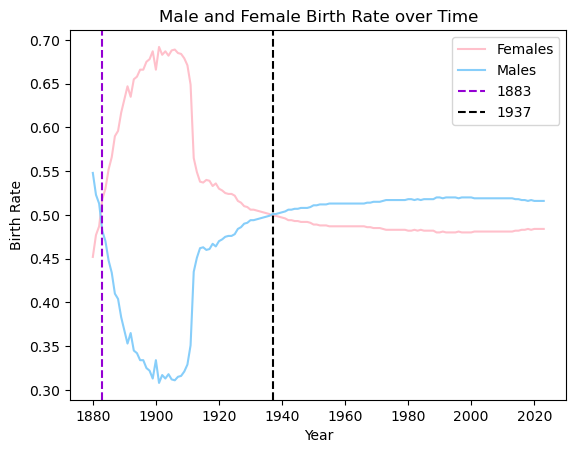

In [11]:
xtitle = 'Year'
ytitle = 'Birth Rate'
title = 'Male and Female Birth Rate over Time'

plt.xlabel(xtitle)
plt.ylabel(ytitle)
plt.title(title)
plt.plot(birth_percentages['year'], birth_percentages['female_br'], color = 'pink', label = 'Females')
plt.plot(birth_percentages['year'], birth_percentages['male_br'], color = 'lightskyblue', label = 'Males')
plt.axvline(x=1883, color='darkviolet', linestyle='--', label='1883') #Found via eda
plt.axvline(x=1937, color='black', linestyle='--', label='1937')
plt.legend();

Yeah, all this adds to a lot of interestng discussions, especially in years 1889 to 1911 that the female birthrate was over 20% that of males, maxing out at 69.2% to 30.8% in 1901.

Pragmatically recall I trend I remember from my actuarial days where apparently the expected age difference was that males would be 3 years older than females. So, on a population basis we might need to offset them by three, but eh...

Note that the first wave of feminism was between 1848 and 1920. While it started with birth trends unknown to us, approximately half way through the poltically active youths and and later leaders were part of a socity with literally just more woman than previously (unfortunately we only have up to 1880). I don't think it's such a stretch to suggest that such ideas would be more likely to be explored and pushed if literally there aren't enough men going on and women ask, "So, what am I supposed to do with my life now?"

In [12]:
# birth_percentages[birth_percentages['female_br']-birth_percentages['male_br']>.2]
# birth_percentages[birth_percentages['female_br']==birth_percentages['female_br'].max()]

Note that unique names are potentially interesting. Ie unique per whatever gender, but likely some minor/major androgynous names exist. Regardless, we'll do a simple unique for now.

## Warnng

As I wrote above. I'm entering a new threshold for names. Hence, excuse me if some of the numbers are off as I might have neglected to change comments about the data. Hence, whatever commentary might reflected the unadulterated (sp?) data.

Truthfully, and by truth I mean I'll admit my laziness, assume that I did not change the commentary unless I happned to notice (relying on my memory) a different trend. Pragmatically minority names affect both genders but I do not anticipate just one being completly changd as a result of the following threshold of what defines a 'name' to be made.

In retrospect, perhaps adding it up would be proper. Ie maybe just 5 Chads in 1880, but once it becomes a truly 'Chad' name then 'add them back' from 1880 as well. Oh well. Pragmatically it still seems valid to judge each year for what it is.

In [31]:
orig = df.shape[0]
df_all = df.copy()

thresh = 10 #See earlier for why by default I'll be choosing 10.

df = df[df['count']>= thresh]
curr = df.shape[0]
print(f"With our minimalist dataframe of {curr} we now have {orig - curr} less than our original {orig} total rows.")

With our minimalist dataframe of 1225306 we now have 891913 less than our original 2117219 total rows.


In [33]:
#Re the unique names - I think it's better to contrast just two years than to do another line graph. I think it'll better
#emphasis the change over time.

#Hmm, should I be writing a formula for this? Eh, at least at the moment... So close to having that though when I have the years
#out in front.

y1 = 1880
y2 = 2023

y1_u_fnames, y1_u_mnames = df[(df['year']==y1)&(df['sex']=='F')].shape[0], df[(df['year']==y1)&(df['sex']!='F')].shape[0] #Perhaps should do count, but eh
y2_u_fnames, y2_u_mnames = df[(df['year']==y2)&(df['sex']=='F')].shape[0], df[(df['year']==y2)&(df['sex']!='F')].shape[0]

y1_avg_fname, y1_avg_mname = df[(df['year']==y1)&(df['sex']=='F')]['count'].mean(), df[(df['year']==y1)&(df['sex']!='F')]['count'].mean()
y2_avg_fname, y2_avg_mname = df[(df['year']==y2)&(df['sex']=='F')]['count'].mean(), df[(df['year']==y2)&(df['sex']!='F')]['count'].mean()

y1_females, y1_males = df[(df['year']==y1)&(df['sex']=='F')]['count'].sum(), df[(df['year']==y1)&(df['sex']!='F')]['count'].sum()
y2_females, y2_males = df[(df['year']==y2)&(df['sex']=='F')]['count'].sum(), df[(df['year']==y2)&(df['sex']!='F')]['count'].sum()

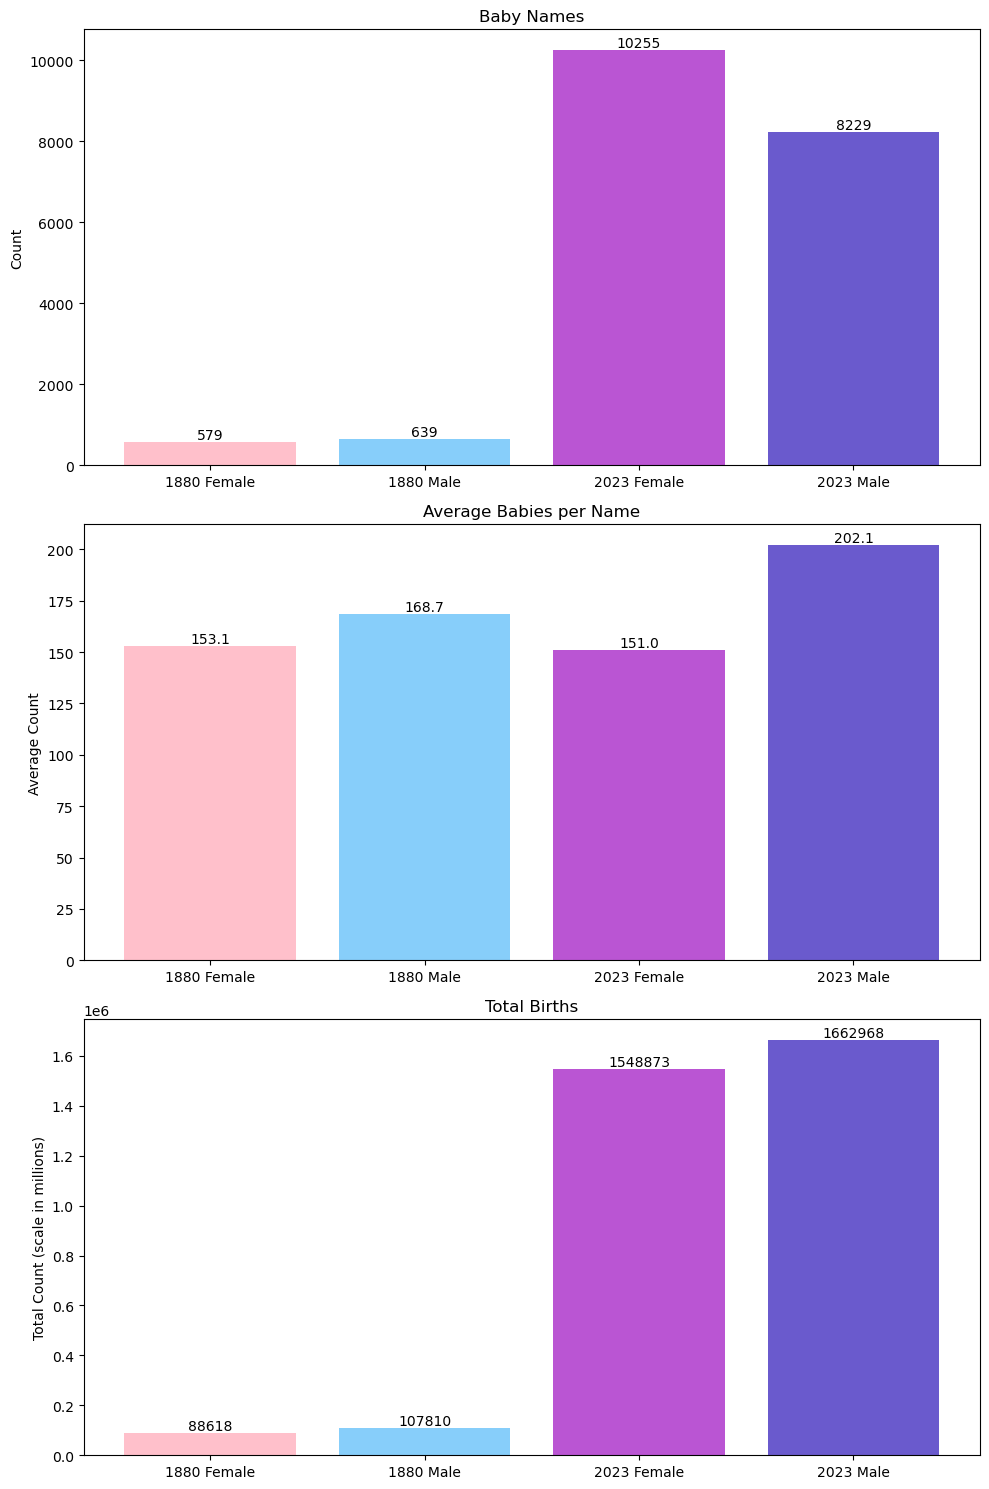

In [34]:
#Honestly tinkered out with ChatGPT. I at least take pride in making the cod as dense as I thought I could.

colors = ['pink', 'lightskyblue', 'mediumorchid', 'slateblue']

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

data = [
    ([y1_u_fnames, y1_u_mnames, y2_u_fnames, y2_u_mnames], 'Baby Names', 'Count'),
    ([y1_avg_fname, y1_avg_mname, y2_avg_fname, y2_avg_mname], 'Average Babies per Name', 'Average Count'),
    ([y1_females, y1_males, y2_females, y2_males], 'Total Births', 'Total Count (scale in millions)')
]

for ax, (values, title, ylabel) in zip(axs, data):
    bars = ax.bar([f'{y1} Female', f'{y1} Male', f'{y2} Female', f'{y2} Male'], values, color=colors)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval) if ylabel == 'Count' or ylabel == 'Total Count' else round(yval, 1), ha='center', va='bottom')

plt.tight_layout()
plt.show();

Anyways, now that the graphs done let's analyze:

When it comes to unique names, females were far less than males in 1880 with that trend changing in 2023 to see quite a significant increase of unique female names to males.

However, it's surprising that when it would come to the average amount of times a name is used, which in retrospect perhaps we should have used the median (but we'll keep matters simple for now at least), the 1880 male name is only negligibly larger than the female name (see below for relative fe/male births and of course the distribution of names which at least as of yet we did not display). In 2023 the trend is as expected where the higher amount of unique female names leads to a lower average amount of females called by said name. Of interest is the disparity though - for every 3 females with the same name (2023) 4 males have the same first name! Such a difference beckons to be examined more in-indepth.

Finally, the total populaton of female and male births in 1880 and 2023 are shown. In both of those years more males are born (see earlier for the propriton throughout time), yet the difference is actually much greater in 1880 than 2023. Although it's beyond the scope of this project, if our analysis is correct thus far - why oh why did rates flucture so much over time? Are men from certain cultures more likely to give birth to daughters, contributing to the bizaare trend noted above?

Although potentially controversial, the reason why I mentioned that is as follows: Upon looking at the population increase, approximately 16x from 1880 to 2023, unique names, particularly among females, proportionally exploded. However, this begs an explanation: Where did all these names come from? Although I think it's reasonable to assume new names within a culture can get added over time, but that many?? Rather, the reasonable assumption is to assume that immigrants added that many new names to the lexicon of baby names. Yet that may?? Then again, the world is a fairly large place... Properly diligance is called for to exame the proportion of trends given. It would seem that in 1880 the USA was likely of a much more monolithic cultural and religious nation and it would be expected that the proprtion of names was much more "even" and distrubted amount the lower-end tail than it is now. So, let us not be lazy and look into that later.

A potential factor to analyze, unavailable to us, is the average family size. I would assume most fathers do not follow the trend of George Foreman, naming all of their sons the same name, save a numerial and later nickname to distinguish them. Of special interest is George VI, "Little Joey", whose nickname includes an actual other name, as opposed to his brothers: "Jr.", "Monk", "Big Wheel", and "Red". Interestingly, he gave his seven daughters all unique names, giving only the fifth the female equivelant: Georgetta (https://en.wikipedia.org/wiki/George_Foreman).

In [35]:
#Tangential, but gah they seemed to be have 'updated' Juypter notebook over the weekend.

target_year = 1880
rank_cutoff = 11

#df[(df['year']==target_year)&(df['rank_of_year']<rank_cutoff)]#I noticed during EDA that sometimes a few of the 'opposite'
#gender will get called that name. So, potential roadblock.

target_name_df = df[(df['year']==target_year)&(df['rank_of_year']<rank_cutoff)][['first', 'sex']]
#Originally was going to do some divde by two thing but eh, we already have the gender from before

#Thanks to ChatGPT for much help in making this more efficient. My original code had at least two for loops in it.

#Sigh, my 'innovation' of target_female_rank_list[name] = [[grouped.loc[(name, 'F')]]] was not effective for graphing
#Purposes due to type mismatches. Caved and used chat gpts and won't bothe to change it.

grouped = df.groupby(['first', 'sex', 'year'])['rank_of_year'].first().unstack(fill_value=0)

target_female_rank_list = {}
for name in target_name_df[target_name_df['sex'] == 'F']['first']:
    if (name, 'F') in grouped.index:
        name_rank = grouped.loc[name, 'F']
        if isinstance(name_rank, pd.Series):
            target_female_rank_list[name] = [name_rank.get(year, None) for year in range(1880, 2024)]
    else:
        target_female_rank_list[name] = [None] * (2024 - 1880)
        
target_male_rank_list = {}
for name in target_name_df[target_name_df['sex'] != 'F']['first']:
    if (name, 'M') in grouped.index: #Eh, ideally would want to do a !F, but for now...
        name_rank = grouped.loc[name, 'M']
        if isinstance(name_rank, pd.Series):
            target_male_rank_list[name] = [name_rank.get(year, None) for year in range(1880, 2024)]
    else:
        target_male_rank_list[name] = [None] * (2024 - 1880)

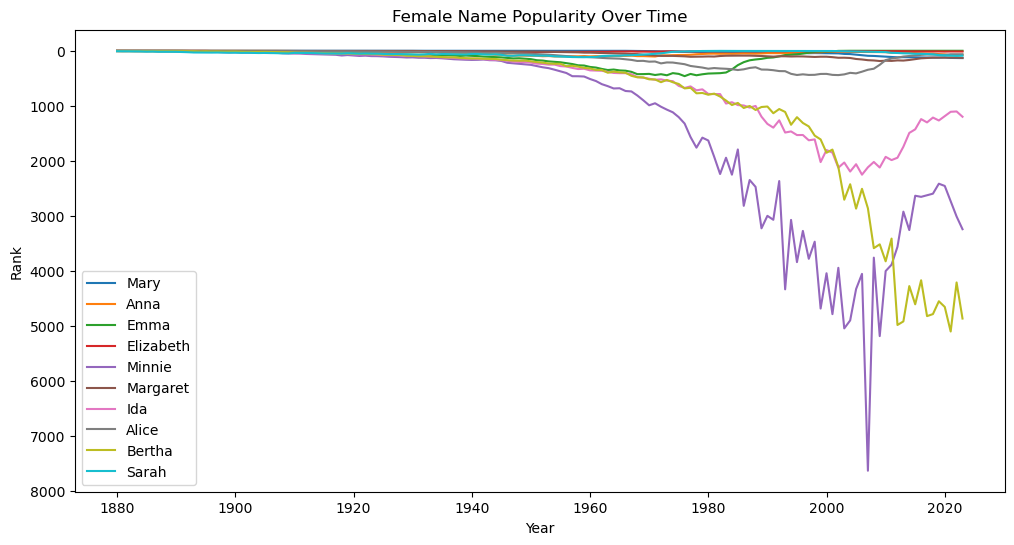

In [36]:
years = list(range(1880, 2024))

plt.figure(figsize=(12, 6))

for name, ranks in target_female_rank_list.items():
    plt.plot(years, ranks, label=name)

plt.xlabel('Year')
plt.ylabel('Rank')
plt.title('Female Name Popularity Over Time')
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis to show rank 1 at the top
plt.show();

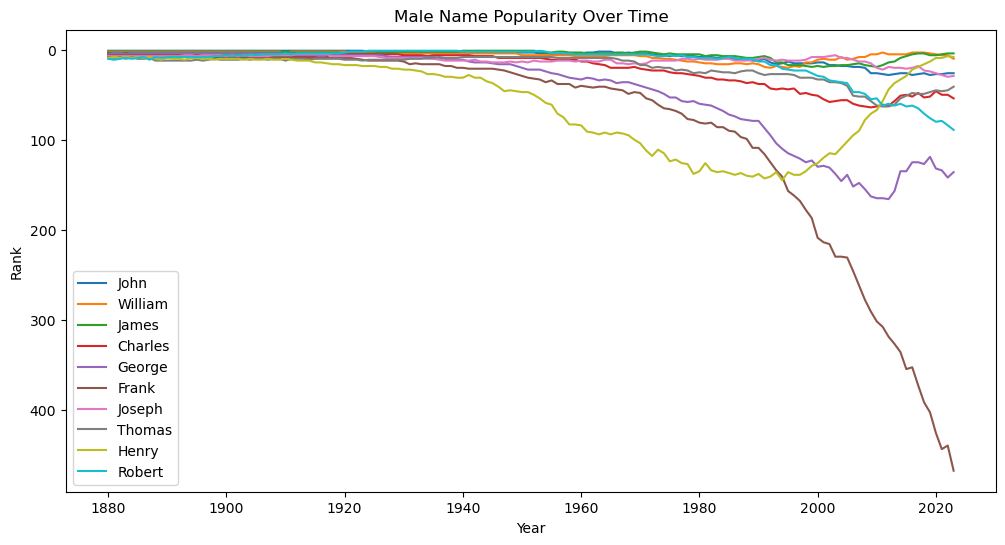

In [37]:
plt.figure(figsize=(12, 6))

for name, ranks in target_male_rank_list.items():
    plt.plot(years, ranks, label=name)

plt.xlabel('Year')
plt.ylabel('Rank')
plt.title('Male Name Popularity Over Time')
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis to show rank 1 at the top
plt.show();

Wow, look at the differences. Of interest is that most f the 'top' names retained their status. With this graph it's honestly hard to tell the precise rank and perhaps we should draw that, but eh.

Of interest is that the popular boy names retained their grip oveerall. Even Frank who did the worse, ending up at 470ish, ended up far better off than the death of Bertha and Minnie, let alone many others.

In a vacuum, this trend is understood as recall the plethora of unique female names. Although we haven't yet explored their distribution, it makes sense that female names would have the most upheaval over time as they have much more competition vying for their babies.

In [38]:
def name_over_time(name, sex_female=False, year_start=1880, year_end=2023):
    #Plots an individual's name popularity over time.
    
    #I'm assuming when running this that matpyplots and numpy have already been imported.

    if sex_female:
        if (name, 'F') in grouped.index:
            name_rank = grouped.loc[name, 'F']
            if isinstance(name_rank, pd.Series):
                ranks = [name_rank.get(year, None) for year in range(year_start, year_end+1)]
    elif (name, 'M') in grouped.index:
        name_rank = grouped.loc[name, 'M']
        if isinstance(name_rank, pd.Series):
            ranks = [name_rank.get(year, None) for year in range(year_start, year_end+1)]
    else:
        ranks = [None] * (year_end + 1 - year_start)

    # years = list(range(1880, 2024))

    if sex_female:
        color = 'pink'
    else:
        color = 'lightskyblue'

    plt.figure(figsize=(12, 6))

    plt.plot(list(range(year_start, year_end+1)), ranks, label=name, color=color)

    plt.xlabel('Year')
    plt.ylabel('Rank')
    plt.title('Male Name Popularity Over Time')
    plt.legend()
    plt.gca().invert_yaxis()  # Invert y-axis to show rank 1 at the top
    plt.show();

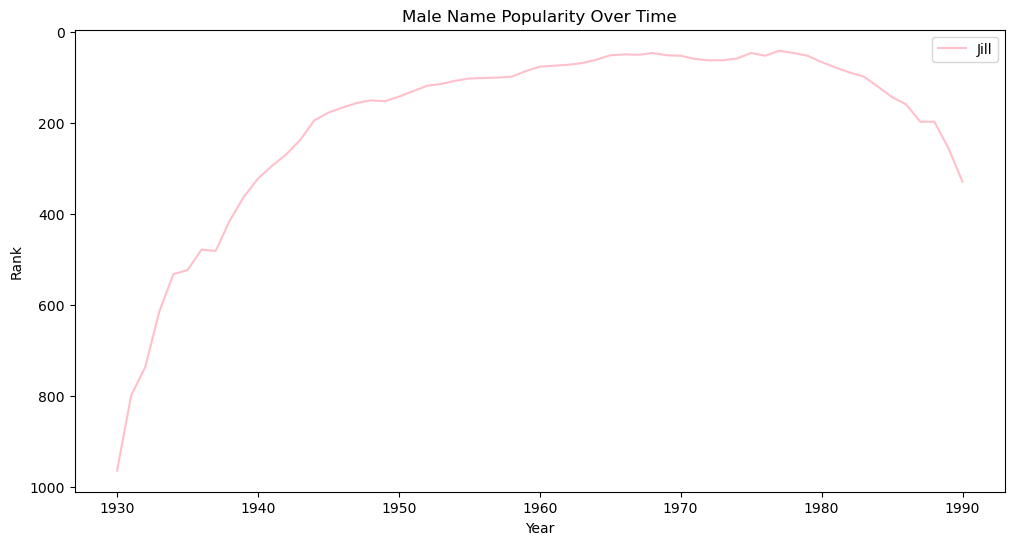

In [39]:
name_over_time('Jill', sex_female=True, year_start=1930, year_end=1990)

In [40]:
#Hmm, should we change this to a formula? Eh...
#Plus, perhaps we should factor this into percentage of total names... we'll do that below.

years = 1880
yeare = 2023

thresh = .0001 #Somewhat arbitrary, but we'll set it at 1 in 10k.

andr_names_over_time= {}

#Potentially the proportion of one gender could be such that to use the per of year of the minor count might be wrong, but eh
#At least it's consistent for all of them.
for year in range(years, yeare+1):
    df_year = df[df['year']==year].sort_values('count', ascending=True).reset_index(drop=True)
    andr_names_peryear = df_year[(df_year['first'].duplicated(keep='last'))&(df_year['per_of_year']>=thresh)].shape[0]
    andr_names_over_time[year] = andr_names_peryear
    
andr_names_df = pd.DataFrame(list(andr_names_over_time.items()), columns=['year', 'count_of_andr_names'])
andr_names_df.head()

,year,count_of_andr_names
0,1880,37
1,1881,39
2,1882,47
3,1883,49
4,1884,55


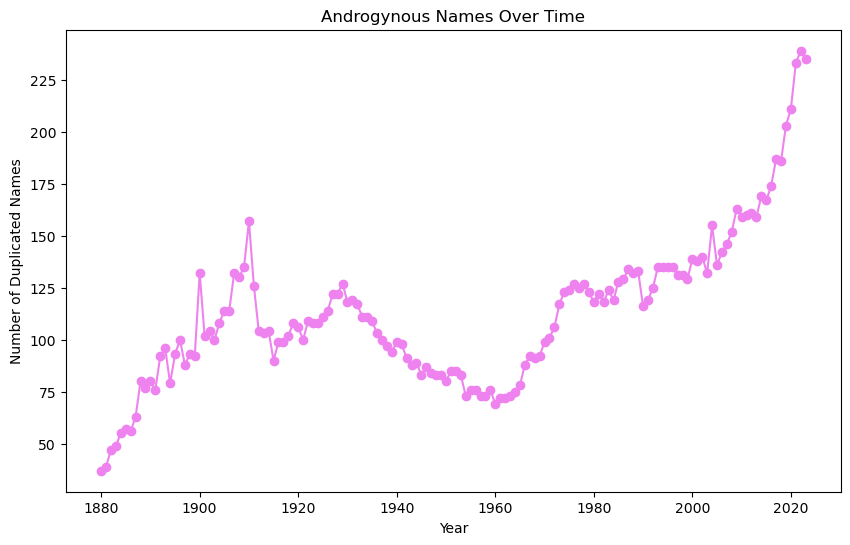

In [41]:
color = 'violet'

plt.figure(figsize=(10, 6))
plt.plot(andr_names_df['year'], andr_names_df['count_of_andr_names'], marker='o', linestyle='-', color=color)
plt.title('Androgynous Names Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Duplicated Names');

In [42]:
#Let's do this now for percentags

years = 1880
yeare = 2023

thresh = .0001

andr_names_over_time_per= {}

for year in range(years, yeare+1):
    df_year = df[df['year']==year].sort_values('count', ascending=True).reset_index(drop=True)
    andr_names_peryear = df_year[(df_year['first'].duplicated(keep='last'))&(df_year['per_of_year']>=thresh)].shape[0]
    uniques = len(df_year['first'].unique())
    andr_names_over_time_per[year] = round((andr_names_peryear * 2) / (uniques + andr_names_peryear), 4)
    
andr_names_over_time_per_df = pd.DataFrame(list(andr_names_over_time_per.items()), columns=['year', 'per_of_andr_names'])
andr_names_over_time_per_df.tail()

,year,per_of_andr_names
139,2019,0.0233
140,2020,0.0248
141,2021,0.0271
142,2022,0.0275
143,2023,0.0273


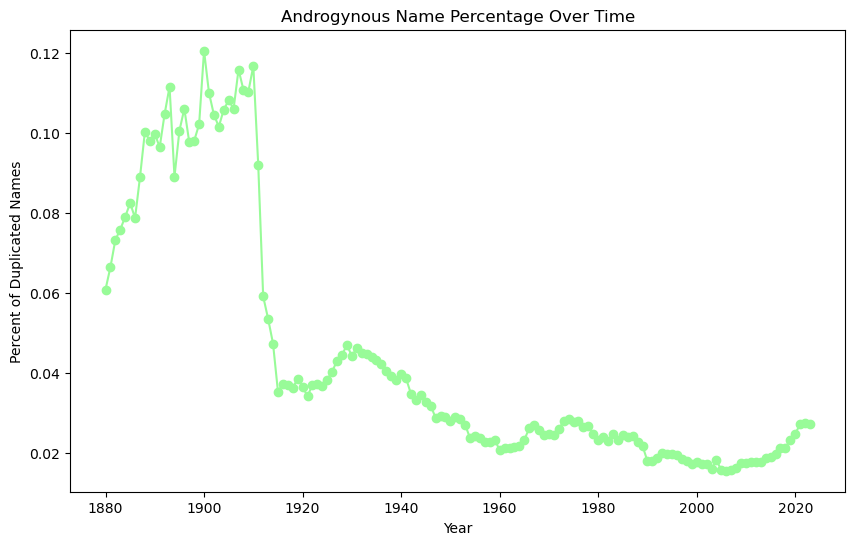

In [43]:
color = 'palegreen'

plt.figure(figsize=(10, 6))
plt.plot(andr_names_over_time_per_df['year'], andr_names_over_time_per_df['per_of_andr_names'], marker='o', linestyle='-', color=color)
plt.title('Androgynous Name Percentage Over Time')
plt.xlabel('Year')
plt.ylabel('Percent of Duplicated Names');

Note the quite small scale on that last visual.<br><br>

Re. the calculation:
Via the unique filter, we'd retain any 'male', 'female' and androgynous names. However, that would only be one instance of them (say with their male counterparts), however we'd need to add back the times that the opposite counterpart (females) also get called that. Hence, our desired fraction is 2a/a+m+f.
<br>
Reminder that our arbitrary guideline for an androgynous name is 1 in 10k. So, although a few females are named 'John' that does not make it a female name.